In [1]:
from typing import Callable

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.lax as lax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jaxtyping import Array, Float  # https://github.com/google/jaxtyping


jax.config.update("jax_enable_x64", True)

In [2]:
# Represents the interval [x0, x_final] discretised into n equally-spaced points.
class SpatialDiscretisation(eqx.Module):
    x0: float = eqx.field(static=True)
    x_final: float = eqx.field(static=True)
    vals: Float[Array, "n"]

    @classmethod
    def discretise_fn(cls, x0: float, x_final: float, n: int, fn: Callable):
        if n < 2:
            raise ValueError("Must discretise [x0, x_final] into at least two points")
        vals = jax.vmap(fn)(jnp.linspace(x0, x_final, n))
        return cls(x0, x_final, vals)

    @property
    def δx(self):
        return (self.x_final - self.x0) / (len(self.vals) - 1)

    def binop(self, other, fn):
        if isinstance(other, SpatialDiscretisation):
            if self.x0 != other.x0 or self.x_final != other.x_final:
                raise ValueError("Mismatched spatial discretisations")
            other = other.vals
        return SpatialDiscretisation(self.x0, self.x_final, fn(self.vals, other))

    def __add__(self, other):
        return self.binop(other, lambda x, y: x + y)

    def __mul__(self, other):
        return self.binop(other, lambda x, y: x * y)

    def __radd__(self, other):
        return self.binop(other, lambda x, y: y + x)

    def __rmul__(self, other):
        return self.binop(other, lambda x, y: y * x)

    def __sub__(self, other):
        return self.binop(other, lambda x, y: x - y)

    def __rsub__(self, other):
        return self.binop(other, lambda x, y: y - x)


def laplacian(y: SpatialDiscretisation) -> SpatialDiscretisation:
    y_next = jnp.roll(y.vals, shift=1)
    y_prev = jnp.roll(y.vals, shift=-1)
    Δy = (y_next - 2 * y.vals + y_prev) / (y.δx**2)
    # Dirichlet boundary condition
    Δy = Δy.at[0].set(0)
    Δy = Δy.at[-1].set(0)
    return SpatialDiscretisation(y.x0, y.x_final, Δy)

First let's try solving this semidiscretisation directly, as a system of ODEs.

In [ ]:
# Problem
def vector_field(t, y, args):
    return laplacian(y) * 2e-4


term = diffrax.ODETerm(vector_field)

def ic(x):
    return jnp.where(x == 1, 1.0, 0.0)


# Spatial discretisation
x0 = 0
x_final = 1
n = 21
y0 = SpatialDiscretisation.discretise_fn(x0, x_final, n, ic)

# Temporal discretisation
t0 = 0
t_final = 2500
δt = 12.5 #0.0001
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t_final, 21))

# Tolerances
rtol = 1e-10
atol = 1e-10
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol#, dtmax=12.5 #0.001
)

In [4]:
solver = diffrax.Tsit5()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    t_final,
    δt,
    y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

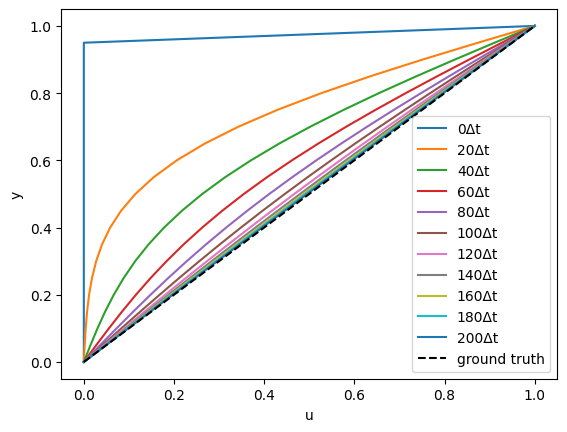

In [10]:
# 假设 sol.ys.vals 是一个二维数组，获取不同的行
indices = np.arange(0, sol.ys.vals.shape[0], 2)  

# 创建一个线性空间的向量，范围从0到1，共21个点
vector = np.linspace(0, 1, 21)

# 绘制 sol.ys.vals 中的 0, 5, 10, 15, ...
for idx in indices:
    plt.plot(sol.ys.vals[idx, :], vector, label=f"{idx*10}Δt")

# 绘制 vector
plt.plot(vector, vector, label="ground truth", linestyle='--', color='k')  # 可视化 vector

# 添加图例和标签
plt.xlabel("u")
plt.ylabel("y")
plt.legend()
plt.show()


In [6]:
# plt.figure(figsize=(5, 5))
# plt.imshow(
#     sol.ys.vals,
#     origin="lower",
#     extent=(x0, x_final, t0, t_final),
#     aspect=(x_final - x0) / (t_final - t0),
#     cmap="inferno",
# )
# plt.xlabel("y")
# plt.ylabel("t", rotation=0)
# plt.clim(0, 1)
# plt.colorbar()
# plt.show()

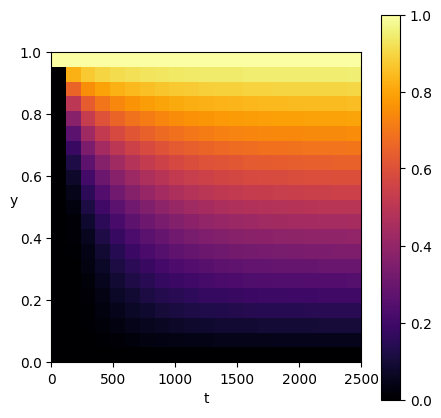

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(
    sol.ys.vals.T,  
    origin="lower",
    extent=(t0, t_final, x0, x_final),  
    aspect=(t_final - t0) / (x_final - x0),  
    cmap="inferno",
)
plt.xlabel("t")
plt.ylabel("y", rotation=0) 
plt.clim(0, 1)
plt.colorbar()
plt.show()
